# mlflow: Bias Variance Data Tradeoff

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

## Generate data

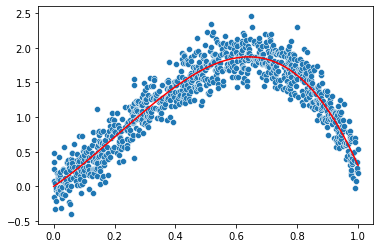

In [3]:
X = np.sort(np.random.uniform(0, 1, 1000))
noise = np.random.normal(0,0.2,1000)
# true function f(x) = 10x - 5x^2 + 0.5x^3
true_function = 3*X + 4*X**2 -6*(X**3)-0.7*(X**4)
y=true_function + noise
sns.scatterplot(x=X, y=y)
sns.lineplot(x=X, y=true_function, color='r')
plt.show()

## Fit initial model

#### Polynomial Features

In [4]:
poly_transf = PolynomialFeatures(degree=4, include_bias = False)
test_poly = poly_transf.fit_transform(X.reshape(-1, 1))
test_poly.shape

(1000, 4)

In [5]:
pd.DataFrame(test_poly).head()

,0,1,2,3
0,0.000192,3.688672e-08,7.084434e-12,1.360630e-15
1,0.000353,1.243286e-07,4.383858e-11,1.545759e-14
2,0.001885,3.554191e-06,6.700560e-09,1.263227e-11
3,0.002441,5.959304e-06,1.454767e-08,3.551331e-11
4,0.002814,7.917136e-06,2.227677e-08,6.268104e-11


In [9]:
features_df = pd.DataFrame(test_poly)
features_df.head()

,0,1,2,3
0,0.000192,3.688672e-08,7.084434e-12,1.360630e-15
1,0.000353,1.243286e-07,4.383858e-11,1.545759e-14
2,0.001885,3.554191e-06,6.700560e-09,1.263227e-11
3,0.002441,5.959304e-06,1.454767e-08,3.551331e-11
4,0.002814,7.917136e-06,2.227677e-08,6.268104e-11


In [10]:
features_df.describe()

,0,1,2,3
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.506836,3.428280e-01,2.595962e-01,2.088652e-01
std,0.293311,3.023667e-01,2.871114e-01,2.695056e-01
min,0.000192,3.688672e-08,7.084434e-12,1.360630e-15
25%,0.259721,6.745513e-02,1.751957e-02,4.550224e-03
50%,0.504899,2.549248e-01,1.287128e-01,6.498813e-02
75%,0.770777,5.940979e-01,4.579173e-01,3.529523e-01
max,0.999580,9.991598e-01,9.987400e-01,9.983204e-01


In [11]:
targets = y

#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.33, random_state=1)

In [12]:
# normalize
## training features
print("\ntrain features pre normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))
scaler = scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print("\ntrain features post normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

## test features
print("\ntest features pre normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))
X_test = scaler.transform(X_test)

print("\ntest features post normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))


train features pre normalization
0    0.504786
1    0.339768
2    0.256590
3    0.206146
dtype: float64
0    0.291694
1    0.301396
2    0.286021
3    0.268045
dtype: float64

train features post normalization
[ 2.26253510e-15 -2.64465067e-16 -3.36049596e-16 -3.54277138e-16]
[1. 1. 1. 1.]

test features pre normalization
0    0.510997
1    0.349041
2    0.265701
3    0.214386
dtype: float64
0    0.296968
1    0.304692
2    0.289652
3    0.272773
dtype: float64

test features post normalization
[0.02130822 0.03079062 0.03187834 0.03076184]
[1.01729636 1.01015693 1.01191651 1.01685515]


In [13]:
#first fit a simple linear regression OR NOT
simple = LinearRegression(fit_intercept=True)
simple.fit(X_train, y_train.reshape(-1,1))

# estimate bias and variance
mse, bias, var = bias_variance_decomp(simple, X_train,
                                      y_train, X_test,
                                      y_test, loss='mse', num_rounds=2000, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.039
Bias: 0.039
Variance: 0.000


In [14]:
r_2 = simple.score(X_test, y_test)
print(f'original model R^2 = {r_2}')

original model R^2 = 0.9008855719768685


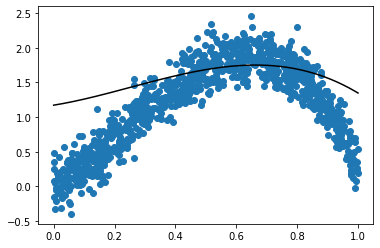

In [15]:
plt.scatter(features_df[0], y)
plt.plot(features_df[0], simple.predict(features_df), color='k')

In [16]:
simple.intercept_

1.1714101716534113

In [17]:
simple.coef_

array([ 0.71240625,  1.84401879, -2.48651666,  0.10442226])

# Pipeline

In [18]:
X_df = pd.DataFrame(X)
X_df.columns = ['col_1']
X_df['target'] = y
X_df.head()

,col_1,target
0,0.000192,-0.154821
1,0.000353,0.355999
2,0.001885,0.257563
3,0.002441,0.484611
4,0.002814,0.074634


In [19]:
train, test = train_test_split(X_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(f"shape train: {train.shape}")
print(f"shape validation: {val.shape}")
print(f"shape test: {test.shape}")

shape train: (640, 2)
shape validation: (160, 2)
shape test: (200, 2)


In [20]:
numeric_features = ['col_1']
numeric_transformer = Pipeline(steps=[
     ('polynomials', PolynomialFeatures(degree=4, include_bias = False)),
     ('scaler', StandardScaler())])

In [21]:
preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features)])

In [22]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
     ('regression', LinearRegression(fit_intercept=True))], verbose=True)

In [23]:
#fit the pipeline
clf.fit(train, train['target'].values)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing regression, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynomials',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['col_1'])])),
                ('regression', LinearRegression())],
         verbose=True)

In [24]:
y_pred = clf.predict(val)

In [25]:
X_df

,col_1,target
0,0.000192,-0.154821
1,0.000353,0.355999
2,0.001885,0.257563
3,0.002441,0.484611
4,0.002814,0.074634
...,...,...
995,0.995352,0.227673
996,0.995942,0.267590
997,0.997486,0.350899
998,0.999176,0.546506


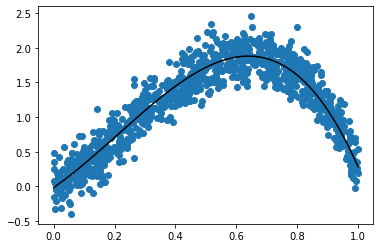

In [26]:
plt.scatter(X_df['col_1'], X_df['target'])
plt.plot(X_df['col_1'], clf.predict(X_df), color='k')

In [27]:
clf.named_steps['regression'].coef_

array([ 0.90323761,  1.23883029, -1.77718215, -0.18401138])

In [28]:
clf.named_steps['regression'].intercept_

1.1668747095091274

In [30]:
clf.named_steps['regression']

LinearRegression()

# mlflow

In [32]:
with mlflow.start_run():
    mlflow.log_metric("r2", r2_score( val['target'].values, y_pred))
    mlflow.log_metric("mse", mean_squared_error( val['target'].values, y_pred))
    mlflow.sklearn.log_model(clf.named_steps['regression'], "regression")

# Model Complexity stuff
will take forever

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.33, random_state=1)

# normalize
## training features
print("\ntrain features pre normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))
scaler = scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

print("\ntrain features post normalization")
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

## test features
print("\ntest features pre normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))
X_test = scaler.transform(X_test)

print("\ntest features post normalization")
print(X_test.mean(axis=0))
print(X_test.std(axis=0))

In [ ]:
alphas = np.linspace(0,5,100)
ddict = {'alpha': [], 'MSE': [], 'Bias': [], 'Variance': [], 'r^2': [],
         'intercept':[],
        }
coefs_dict = {'coef_'+str(i+1):[] for i in range(X_train.shape[1])}

ddict.update(coefs_dict)
for alpha in alphas:
    rg = linear_model.Ridge(alpha=alpha)   
    rg.fit(X_train, y_train.reshape(-1,1))

    # estimate bias and variance
    mse, bias, var = bias_variance_decomp(rg, X_train,
                                          y_train, X_test,
                                          y_test, loss='mse', num_rounds=2000, random_seed=1)
    
    r_2 = rg.score(X_test, y_test)
    new_dict = {'MSE': mse, 'Bias': bias, 'Variance': var, 'r^2': r_2}
    ddict['alpha'].append(alpha)
    ddict['MSE'].append(new_dict['MSE'])
    ddict['Bias'].append(new_dict['Bias'])
    ddict['Variance'].append(new_dict['Variance'])
    ddict['r^2'].append(new_dict['r^2'])
    ddict['intercept'].append(rg.intercept_)
    
    for i in range(len(rg.coef_)):
        coef_key = 'coef_'+str(i+1)
        ddict[coef_key] = rg.coef_[i]
    

In [ ]:
results = pd.DataFrame(ddict)
results.head(n=10)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# results.head(5)
sns.lineplot(x='alpha', y='Bias', data=results, ax=ax[0])
sns.lineplot(x='alpha', y='Variance', data=results, ax=ax[0])
ax_plot1 = sns.lineplot(x='alpha', y='MSE', data=results, ax=ax[0])
ax_plot1.set_title('MSE, BIAS, Variance')

ax_plot_2 = sns.lineplot(x='alpha', y='r^2', data=results, ax=ax[1])
ax_plot_2.set_title("R^2")

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), constrained_layout=True)
sns.relplot(x='r^2', y='Bias', data=results, ax=ax[0])
sns.relplot(x='r^2', y='Variance', data=results, ax=ax[1])
sns.relplot(x='r^2', y='MSE', data=results, ax=ax[2])
# plt.close(2)
# plt.close(3)
# plt.close(4)
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), constrained_layout=True)
sns.lineplot(x='alpha', y='Variance', data=results, ax=ax[0])
sns.lineplot(x='alpha', y='Bias', data=results, ax=ax[1])
sns.lineplot(x='alpha', y='MSE', data=results, ax=ax[2])
plt.show()

In [ ]:
results['alpha'][results['MSE']==results['MSE'].min()]

In [ ]:
plt.figure(figsize=(20,10))
for i in range(X_train.shape[1]):
    var_name = 'coef_'+str(i+1)
    sns.lineplot(x='alpha', y=var_name, data=results)
plt.ylabel("Coef estimate", size=15)
plt.title("Coef estimate by alpha", size=18)

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x='alpha', y='intercept', data=results)
plt.ylabel("intercept estimate", size=15)
plt.title("intercept estimate by alpha", size=18)